In [2]:
# import packages
from astropy.io import fits
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from lmfit import Model, fit_report
from lmfit.models import LinearModel

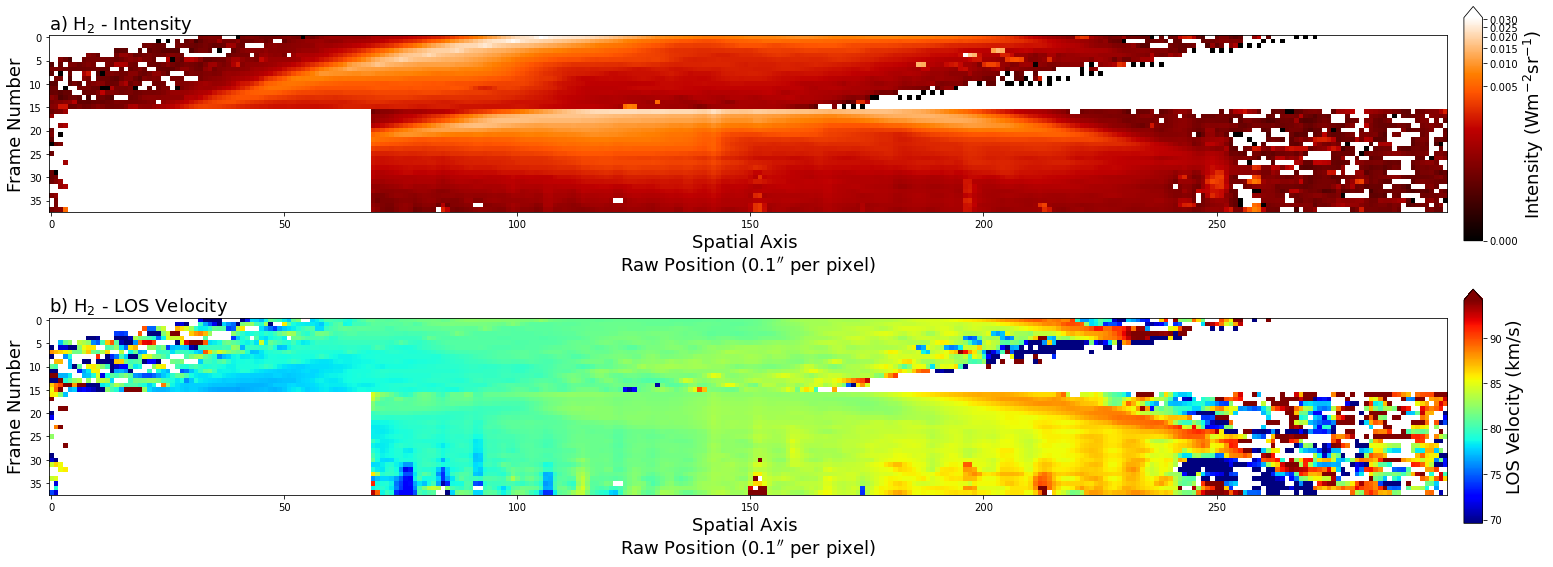

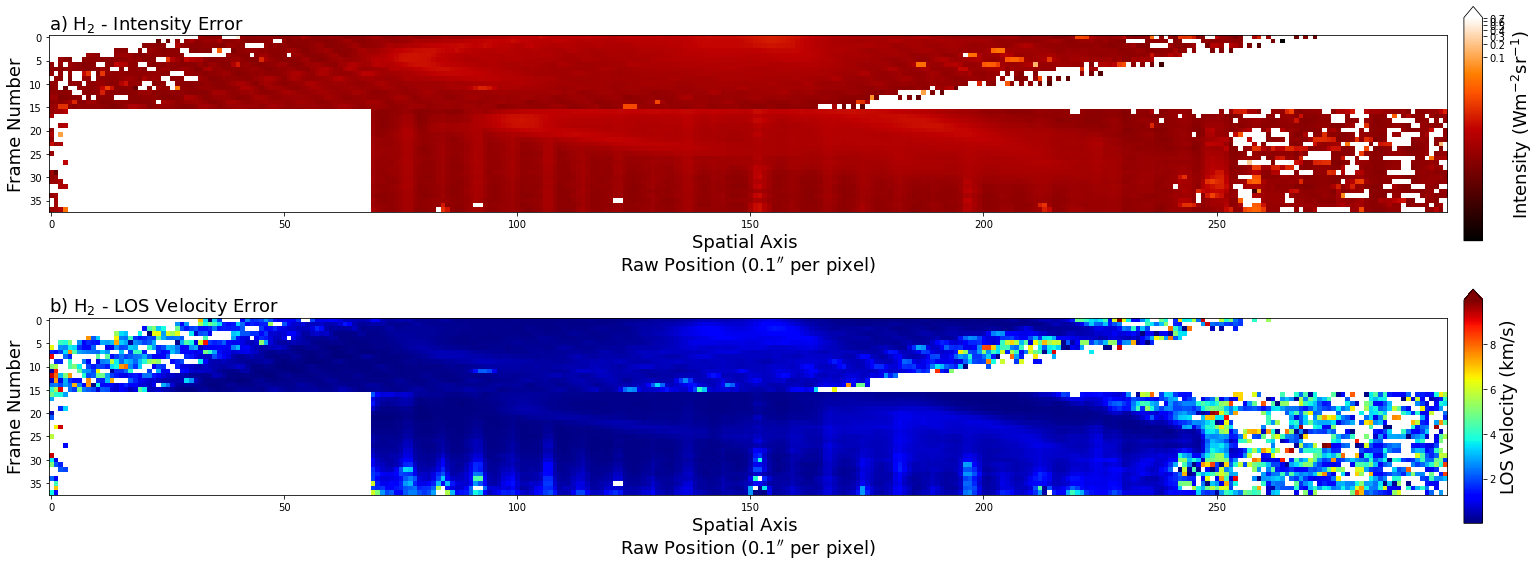

In [2]:
h2_int_shifted = fits.open('h2_int_shifted.fits', ignore_missing_end=True)[0].data
h2_los_shifted = fits.open('h2_los_shifted.fits', ignore_missing_end=True)[0].data
h2_int_shifted_error = fits.open('h2_int_shifted_error.fits', ignore_missing_end=True)[0].data
h2_los_shifted_error = fits.open('h2_los_shifted_error.fits', ignore_missing_end=True)[0].data

fig = plt.figure(figsize=(24,8), tight_layout=True)

fig.add_subplot(211)
plt.imshow(h2_int_shifted, cmap='gist_heat', norm=colors.PowerNorm(gamma=0.2))
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=18)
plt.ylabel('Frame Number', fontsize=18)
plt.title('a) H$_2$ - Intensity', loc='left', fontsize=18)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='Intensity (Wm$^{-2}$sr$^{-1}$)',size=18)

fig.add_subplot(212)
plt.imshow(h2_los_shifted, cmap='jet')
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=18)
plt.ylabel('Frame Number', fontsize=18)
plt.title('b) H$_2$ - LOS Velocity', loc='left', fontsize=18)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='LOS Velocity (km/s)',size=18)


fig = plt.figure(figsize=(24,8), tight_layout=True)

fig.add_subplot(211)
# colMap = cm.gist_heat
# colMap.set_bad(color='white')
plt.imshow(h2_int_shifted_error, cmap='gist_heat', norm=colors.PowerNorm(gamma=0.1))
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=18)
plt.ylabel('Frame Number', fontsize=18)
plt.title('a) H$_2$ - Intensity Error', loc='left', fontsize=18)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='Intensity (Wm$^{-2}$sr$^{-1}$)',size=18)

fig.add_subplot(212)
plt.imshow(h2_los_shifted_error, cmap='jet')
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=18)
plt.ylabel('Frame Number', fontsize=18)
plt.title('b) H$_2$ - LOS Velocity Error', loc='left', fontsize=18)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='LOS Velocity (km/s)',size=18)

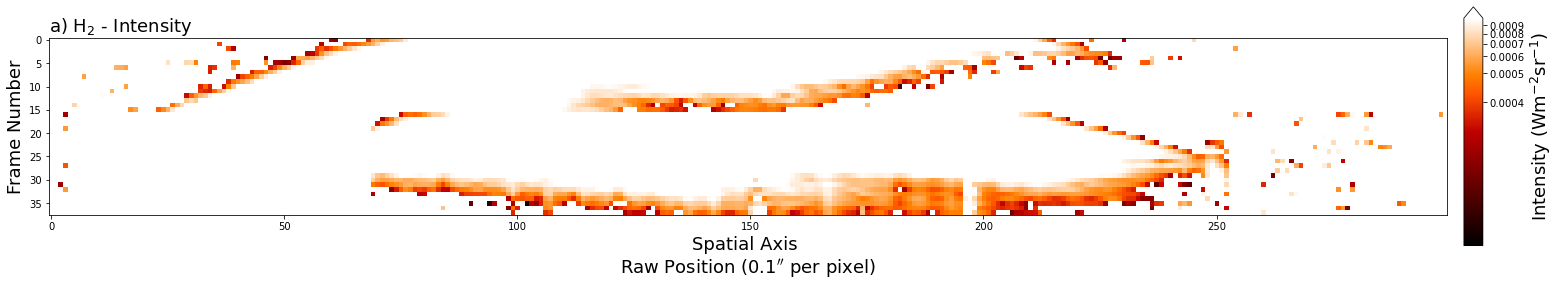

In [3]:
h2_bright2 = h2_int_shifted + 0
h2_bright2[h2_int_shifted > 0.003*1/3] = np.nan
h2_bright2[h2_int_shifted < 0.001*1/3] = np.nan

# h2_bright2[:,70:] = np.nan

fig = plt.figure(figsize=(24,4), tight_layout=True)

fig.add_subplot(111)
plt.imshow(h2_bright2, cmap='gist_heat', norm=colors.PowerNorm(gamma=0.2))
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=18)
plt.ylabel('Frame Number', fontsize=18)
plt.title('a) H$_2$ - Intensity', loc='left', fontsize=18)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='Intensity (Wm$^{-2}$sr$^{-1}$)',size=18)

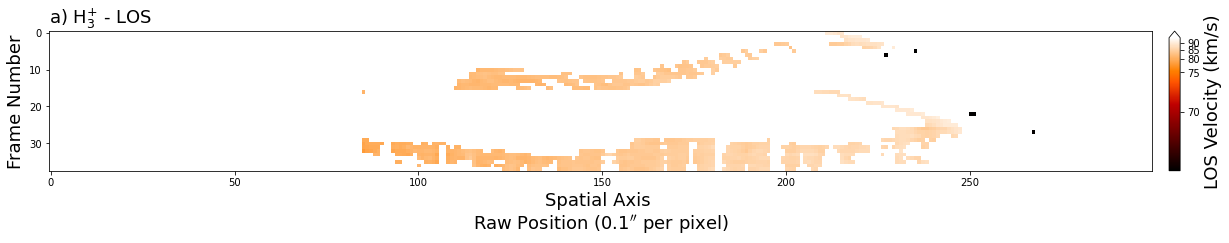

In [4]:
los_vel4 = h2_los_shifted + 0
los_vel4[h2_los_shifted_error > 0.8] = np.nan
los_vel4[:][np.isnan(h2_bright2[:])] = np.nan
# los_vel4[los_vel4 < 80] = np.nan
# los_vel4[los_vel4 > 88] = np.nan
los_vel4[:,:85] = np.nan
# los_vel4[:,250:] = np.nan
# los_vel4[:16,:][los_vel4[:16,:] < 77.5] = np.nan
# los_vel4[:,:120][los_vel4[:,:120] < 82.5] = np.nan
# los_vel4[:,120:180][los_vel4[:,120:180] < 82] = np.nan
# los_vel4[:,120:180][los_vel4[:,120:180] > 85] = np.nan

fig = plt.figure(figsize=(24,8), tight_layout=True)

fig.add_subplot(313)
plt.imshow(los_vel4, cmap='gist_heat', norm=colors.PowerNorm(gamma=0.2))
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=18)
plt.ylabel('Frame Number', fontsize=18)
plt.title('a) H$_3^{+}$ - LOS', loc='left', fontsize=18)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='LOS Velocity (km/s)',size=18)

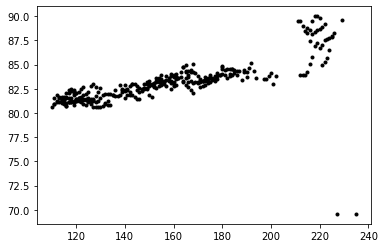

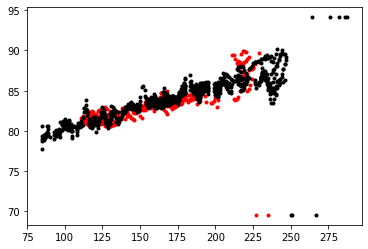

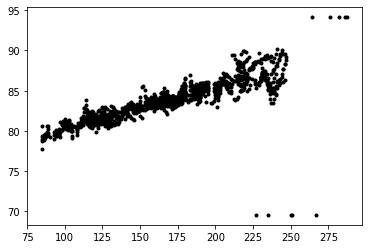

In [5]:
arr = los_vel4 + 0
for i in range(0,300):
    arr[:,i] = i
xt = arr[:16][np.isfinite(los_vel4[:16])]
vt = los_vel4[:16][np.isfinite(los_vel4[:16])]

xb = arr[16:][np.isfinite(los_vel4[16:])]
vb = los_vel4[16:][np.isfinite(los_vel4[16:])]

x = arr[:][np.isfinite(los_vel4[:])]
v = los_vel4[:][np.isfinite(los_vel4[:])]

plt.figure()
plt.plot(xt,vt, 'k.')
# plt.vlines(150, ymin=72, ymax=95, color='b')
# plt.hlines(83.8, xmin=0, xmax=300)

plt.figure()
plt.plot(xt,vt, 'r.')
plt.plot(xb, vb, 'k.')
# plt.vlines(150, ymin=82, ymax=85, color='b')

plt.figure()
plt.plot(x, v, 'k.')

82.79690170027266
0.4518559178720509


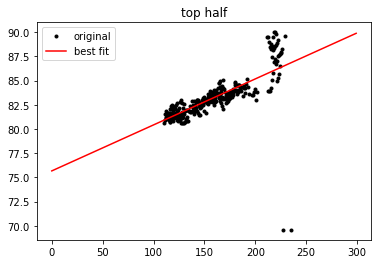

In [6]:
arr = los_vel4 + 0
for i in range(0,300):
    arr[:,i] = i
xt = arr[:16][np.isfinite(los_vel4[:16])]
vt = los_vel4[:16][np.isfinite(los_vel4[:16])]

mod = LinearModel()

pars = mod.guess(vt, x=xt)
out = mod.fit(vt, pars, x=xt)

mt = out.params['slope'].value
bt = out.params['intercept'].value
sig_mt = out.params['slope'].stderr
sig_bt = out.params['intercept'].stderr

# x_fit = np.linspace(110,219,110)
xtf = np.linspace(0,299,300)
vtf = mt * xtf + bt
vterr = np.sqrt(sig_mt**2 + sig_bt**2)

plt.figure()
plt.plot(xt, vt,'.k', label = 'original')
plt.plot(xtf, vtf, 'r', label = 'best fit')
plt.title('top half')
plt.legend()

print(vtf[np.where(xtf==150)][0])
print(vterr)

83.0054810129931
0.20088360405681743


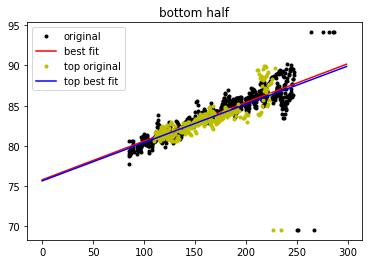

In [7]:
arr = los_vel4 + 0
for i in range(0,300):
    arr[:,i] = i
xb = arr[16:][np.isfinite(los_vel4[16:])]
vb = los_vel4[16:][np.isfinite(los_vel4[16:])]

mod = LinearModel()

pars = mod.guess(vb, x=xb)
out = mod.fit(vb, pars, x=xb)

mb = out.params['slope'].value
bb = out.params['intercept'].value
sig_mb = out.params['slope'].stderr
sig_bb = out.params['intercept'].stderr

# x_fit = np.linspace(110,219,110)
xbf = np.linspace(0,299,300)
vbf = mb * xbf + bb
vberr = np.sqrt(sig_mb**2 + sig_bb**2)

plt.figure()
plt.plot(xb, vb,'.k', label = 'original')
plt.plot(xbf, vbf, 'r', label = 'best fit')
plt.plot(xt, vt,'.y', label = 'top original')
plt.plot(xtf, vtf, 'b', label = 'top best fit')
# plt.ylim(80,90)
plt.title('bottom half')
# plt.vlines(195, ymin=82, ymax=85, color='b')
# plt.hlines(83.8, xmin=0, xmax=300)
plt.legend()

print(vbf[np.where(xbf==150)][0])
print(vberr)

0.4742748023484115


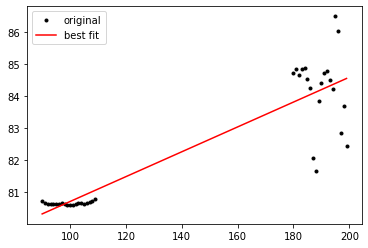

In [20]:
# subtract velocity at center of planet
# top half [:16]
crop1a = np.delete(h2_los_shifted[3:6], np.s_[110:], axis=1)
crop1b = np.delete(crop1a, np.s_[:90], axis=1)
crop2a = np.delete(h2_los_shifted[7:10], np.s_[200:], axis=1)
crop2b = np.delete(crop2a, np.s_[:180], axis=1)
# crop1a = np.delete(h2_los_shifted[6:9], np.s_[140:], axis=1)
# crop1b = np.delete(crop1a, np.s_[:130], axis=1)
# crop2a = np.delete(h2_los_shifted[10:13], np.s_[165:], axis=1)
# crop2b = np.delete(crop2a, np.s_[:155], axis=1)

# plt.figure(figsize=(10,5))
# plt.imshow(crop1b, cmap='jet', norm=colors.PowerNorm(gamma=0.2))

# plt.figure(figsize=(10,5))
# plt.imshow(crop2b, cmap='jet', norm=colors.PowerNorm(gamma=0.2))

avg_crop1b = np.mean(crop1b, axis=0)
avg_crop2b = np.mean(crop2b, axis=0)
line1 = np.linspace(90,110,20,endpoint=False)
line2 = np.linspace(180,200,20,endpoint=False)
# line1 = np.linspace(130,140,10,endpoint=False)
# line2 = np.linspace(155,165,10,endpoint=False)

line_tot = np.concatenate((line1,line2))
avg_crop_tot = np.concatenate((avg_crop1b, avg_crop2b))

# best fit line
mod = LinearModel()

pars_crop = mod.guess(avg_crop_tot, x=line_tot)
out_crop = mod.fit(avg_crop_tot, pars_crop, x=line_tot)

# print(out.fit_report(min_correl=0.25))

m = out_crop.params['slope'].value
y0 = out_crop.params['intercept'].value
sig_m = out_crop.params['slope'].stderr
sig_y0 = out_crop.params['intercept'].stderr

# x_fit = np.linspace(110,219,110)
x_fit = np.linspace(90,200,110,endpoint=False)
avg_crop_best_fit = m * x_fit + y0
avg_crop_error = np.sqrt(sig_m**2 + sig_y0**2)
print(avg_crop_error)

plt.figure()
plt.plot(line_tot, avg_crop_tot,'.k', label = 'original')
plt.plot(x_fit, avg_crop_best_fit, 'r', label = 'best fit')
plt.legend()

In [7]:
# bottom half [16:]
box1a = np.delete(h2_los_shifted[30:35], np.s_[210:], axis=1)
box2a = np.delete(box1a, np.s_[:100], axis=1)

# plt.figure(figsize=(10,5))
# plt.imshow(box, cmap='jet', norm=colors.PowerNorm(gamma=0.2))

avg_box = np.mean(box2a, axis=0)

x_axis = np.linspace(100,209,110)

mod = LinearModel()

pars_box = mod.guess(avg_box, x=x_axis)
out_box = mod.fit(avg_box, pars_box, x=x_axis)

# print(out.fit_report(min_correl=0.25))

k = out_box.params['slope'].value
b = out_box.params['intercept'].value
sig_k = out_box.params['slope'].stderr
sig_b = out_box.params['intercept'].stderr

avg_box_best_fit = k * x_axis + b
avg_box_error = np.sqrt(sig_k**2 + sig_b**2)
print(avg_box_error)

plt.figure()
plt.plot(x_axis, avg_box,'.k', label = 'original')
# np.savetxt('h2_box.txt', avg_box)
plt.plot(x_axis, avg_box_best_fit, 'r', label = 'best fit')
plt.legend()

LinAlgError: SVD did not converge in Linear Least Squares

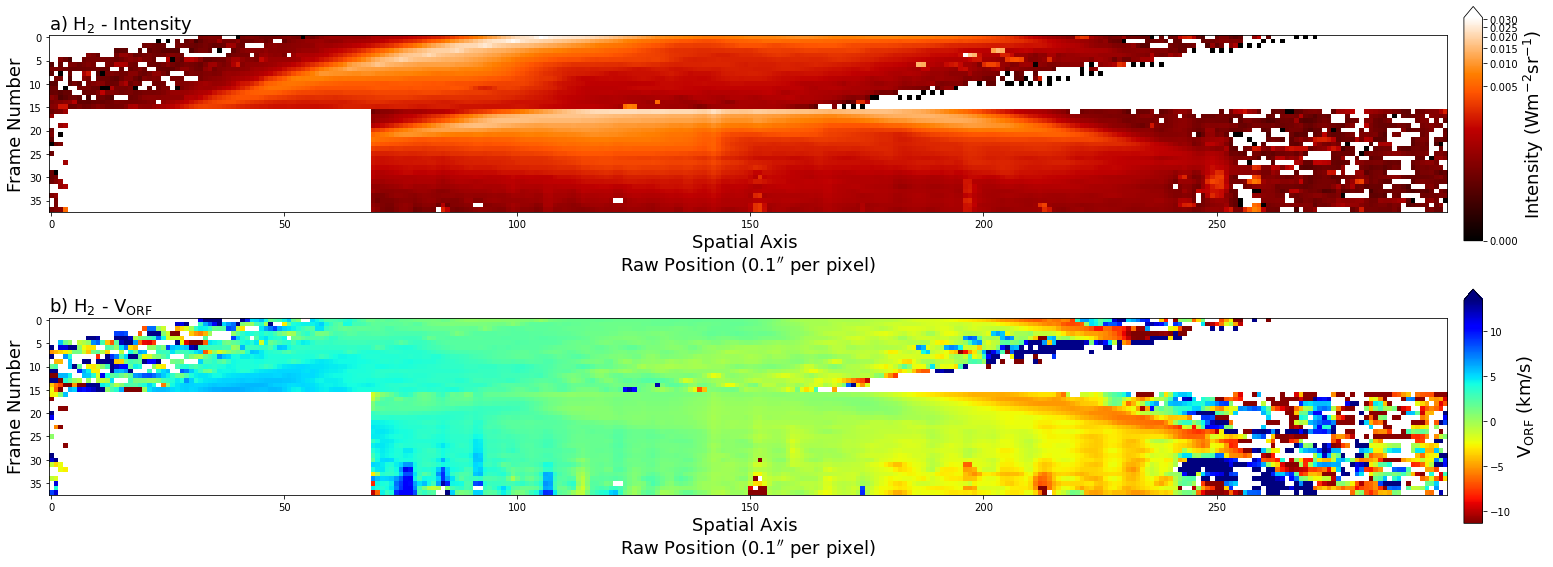

In [8]:
h2_los_shifted_sec1 = np.delete(h2_los_shifted, np.s_[16:], axis=0)
h2_los_shifted_sec2 = np.delete(h2_los_shifted, np.s_[:16], axis=0)

h2_los_rel_sec1 = h2_los_shifted_sec1 - vtf[np.where(xtf==150)][0]
h2_los_rel_sec2 = h2_los_shifted_sec2 - vbf[np.where(xbf==150)][0]
# h2_los_rel_sec1 = h2_los_shifted_sec1 - avg_crop_best_fit[np.where(x_fit==150)][0]
# h2_los_rel_sec2 = h2_los_shifted_sec2 - avg_box_best_fit[np.where(x_axis==150)][0]

h2_los_rel = np.vstack((h2_los_rel_sec1, h2_los_rel_sec2))

# h2_int_shifted[np.isnan(h2_int_shifted_error)] = np.nan
# h2_los_rel[np.isnan(h2_los_shifted_error)] = np.nan
# h2_los_rel[h2_los_rel>=6] = 6
# h2_los_rel[h2_los_rel<=-6] = -6


fig = plt.figure(figsize=(24,8), tight_layout=True)

fig.add_subplot(211)
plt.imshow(h2_int_shifted, cmap='gist_heat', norm=colors.PowerNorm(gamma=0.2))
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=18)
plt.ylabel('Frame Number', fontsize=18)
plt.title('a) H$_2$ - Intensity', loc='left', fontsize=18)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='Intensity (Wm$^{-2}$sr$^{-1}$)',size=18)

fig.add_subplot(212)
plt.imshow(h2_los_rel*(-1), cmap='jet_r')
# plt.imshow(h2_los_rel, cmap='jet')
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=18)
plt.ylabel('Frame Number', fontsize=18)
plt.title('b) H$_2$ - V$_{\mathrm{ORF}}$', loc='left', fontsize=18)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='V$_{\mathrm{ORF}}$ (km/s)',size=18)

nan
nan
nan
nan
nan
nan
2.602324207410416e-06
nan
nan
nan
5.186666180953488e-06
4.479139566787932e-05
2.048415138652059e-05
-1.1596421572204258e-05
nan
nan
nan
nan
-1.3933274040934182e-05
-3.7474063411322404e-05
nan
nan
nan
nan
nan
nan
nan
6.385988529310601e-06
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-9.62159099596106e-06
7.854514697898068e-06
1.7167275080812878e-05
2.9914288279501316e-05
2.2525765789032683e-05
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
5.00397127431597e-05
nan
nan
nan
nan
-5.2682029825827634e-05
2.324863866590291e-05
nan
nan
nan
nan
nan
-1.344981504277154e-05
-1.8109024405417315e-05
1.6042009923900697e-06
nan
nan
nan
nan
3.921959519381713e-05
0.00046130863378184624
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
9.747931667059439e-06
5.189491373977508e-05
0.0004525181700531086
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
n

6.326326744288385e-05
7.51612783965748e-05
0.00032793350187050553
0.0005798853874402251
0.0006174110903813493
0.0002179734803382312
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.368880969501997e-05
-0.00013416005185607654
nan
nan
nan
2.2544966798312814e-05
-5.091877676828658e-06
3.40213618120985e-05
5.849870202613946e-05
0.00011268767908722877
0.0004225038823003999
0.0006626846196047488
0.0005963278850936939
4.835438015035219e-05
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
2.974939076985334e-05
5.418658794348249e-05
4.256916663980949e-05
2.9222774798581656e-05
0.0001483381050775147
0.0005286651517580753
0.0007350603409983412
0.0005400161323473114
-0.00011999544259268767
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
4.476635323277423e-05
2.2267339369317664e-06
4.970872224648563e-05
6.012782043913502e-05
5.56297057907265e-05
0.00018177825721556163

nan
nan
nan
nan
nan
nan
nan
nan
4.6505236911121434e-05
0.00021889056857934725
0.00032844045203986707
0.0004946789977831414
0.0013549889576646048
0.0023696444122441353
0.0012504218989423561
-0.0009806624176492244
-0.0015282576540080264
-0.0008761963286674302
-0.0005918189741374808
-0.0006013813308830061
-0.0004237619957875175
-0.00021365032939431729
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
7.444084557023655e-05
0.00025696147987746925
0.000398910180508147
0.0006299546325102129
0.0016606831105343738
0.002428838892397405
0.0008028533324943004
-0.0012742369872482794
-0.0015306049936225606
-0.0008292118988923328
-0.0005334841261240755
-0.000587460698010695
-0.0004385301502982555
-0.00017761781010935105
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
9.966498705327984e-05
0.00027090372039150217
0.0004930367604235619
0.0008024124156395238
0.002012657023985789
0.0026247916971335276
0.00028647893401235504
-0.00166711232675266

-0.0008444176490958709
-0.0006107889602983939
-0.00037188628793323486
-0.00016977761710622102
-0.0001227715571711387
-0.00014273071719542413
-0.00017096500973193339
-0.00015429908042328207
-7.084976854225729e-05
-0.00010286810175904807
-5.113295549611974e-05
-1.6290962720712633e-05
-1.7131805577939136e-05
7.942922350494795e-06
0.0011872259487938068
0.0032936037273795776
0.004217109280661222
0.002447880122102137
-0.001551984090477295
-0.0031338186744342376
-0.001594481368381086
-0.0013348860233282946
-0.0010677779585906953
-0.0005117720790007154
-0.00039300668274838604
-0.0004467319491314064
-0.0004643704184123178
-0.00033391819338642287
0.00025179848876465355
0.000728359761253902
0.002132300588812577
0.002123674088229664
-0.0009214144102502615
-0.0019398733416825546
-0.0007460954754191168
-0.0005610740721863497
-0.0003730604845080957
-0.00017006175776804753
-8.135249037612212e-05
-0.00010113794793869938
-0.00020531751976093666
-0.00017466470803897244
-2.5877599045151154e-05
-0.00011992

-0.00048654717953221455
-0.000285726872810697
-0.00028672465102372443
0.0026031854186757348
0.0028317372447645827
0.0005090874918081446
-0.002692510484988248
-0.002180691494215077
-0.0010549389706765496
-0.0005065563815736039
-0.00043957170197033964
-0.0004383048058554471
-0.00023798690784879672
-9.508292212541012e-05
-0.00020037636336382855
-0.00021878635490664065
-0.00014518255812854305
-0.00011252766372150719
-9.04870105769577e-05
-6.720398164603887e-05
-2.5557821871597416e-05
-2.9265006539019596e-05
-6.145888703442095e-05
0.005146973317198876
0.0007453399662023727
-0.002404816717589797
-0.0016101730133071188
-0.0013450120462857856
-0.0013753341630174023
-0.0011129582157133177
-0.000860898900956259
-0.0009494556159520455
-0.0006287435399793908
-0.00031014691513872117
-0.0003532387845698627
-0.0002741910786678162
-0.00026950068818229044
0.0029011739949769896
0.002691018273598326
5.620483570961156e-05
-0.0028152749106945436
-0.002084031470165981
-0.0010535314540931415
-0.0004984953549

-6.619684776989826e-05
-4.7997657834010987e-05
-4.500797580915089e-05
-4.01161968813041e-05
-0.003259094406658329
-0.004070823131618481
-0.0026102295637116784
-0.001234158217094953
-0.00100671832654913
-0.0006872849175307326
-0.00031918633076066317
-0.00018231065470704876
-0.00014193564972625299
-0.0002461600833056411
-0.00030447361812291395
-0.00022656428794065467
-0.00014690509027694728
-6.942475144841934e-05
0.002221106779580314
-0.0014289144641292922
-0.0020836919626428356
-0.0013540522283140306
-0.0011557697507361122
-0.0009208824852310676
-0.0006507963125484337
-0.0005851995771146237
-0.0005009828499529727
-0.0002566776758952602
-0.0001277762674157996
-0.0002215068557525693
-0.0003004880276493882
-0.00022141708401391639
-0.00012867449637870697
-0.00011778103776758438
-6.367212280849197e-05
-5.07809384812743e-05
-5.18035521870584e-05
-4.935038809395257e-05
-0.0044976924492055315
-0.004053508685078373
-0.002515593180897731
-0.0011406615712757865
-0.0009530683325339132
-0.0007019269

-0.0008670723018351575
-0.0010290217459061873
-0.0009753240046046774
-0.0006607240873473677
-0.0005822821450529366
-0.0005887412946564349
-0.000313238528835043
-0.00020708456268010364
-0.0004094823679948213
-0.00038876703175830187
-0.0002744144721164316
-0.00018846728288410557
-0.00016663794158707434
-0.00013348166524905557
-8.957630382753546e-05
-5.7778155453280865e-05
-6.248363228871385e-05
-0.00396921534627726
-0.0018525663388076832
-0.0008454579729816258
-0.0007110234899856656
-0.0007256130769981617
-0.0005277833086930663
-0.0002902392895960076
-0.0002038282635222423
-0.00014434050529519345
-8.40826746017078e-05
-3.662799880768805e-05
-7.440651976516359e-05
-7.297959100038419e-05
3.560569846467994e-05
-0.0025499018250115697
-0.0015759121891595618
-0.0012729563693798657
-0.000821649401752023
-0.0009776742433570285
-0.0009557501295661694
-0.0006750099887831602
-0.000592475319681882
-0.0005657747890832291
-0.0002729693820991085
-0.00019648882248371122
-0.0004127215313879935
-0.0003944

2.4837152988323608e-05
-0.00025161024768735477
-0.0003647070825466177
-0.00013434863838994687
-9.862587548887278e-05
-0.00011646909225749647
-3.9287733698516484e-05
-0.00010277760270174644
-0.00017887974163805507
-0.00014406356663841375
-7.001456736068981e-05
-0.003212010181783683
-0.0014384100968831016
-0.0014028521019476305
-0.0008372150766161835
-0.00044266038747593685
-0.0003361269780750766
-0.0004916193973534301
-0.0006316120971333189
-0.000583720819446628
-0.00018295642345151058
-8.463585984036731e-05
-0.00031635475753809435
-0.00031158352521076967
-0.0002482198554220245
-0.0001421344623480053
-0.0001222189502288638
-0.00016069079271040416
-0.00013214167379147347
-8.5844740262716e-05
-7.173743394917889e-05
-0.0016589007786982843
-0.0007482619955068268
-0.00022521344018667675
-1.8664759380982842e-05
-0.00022057173009366621
-0.0003162295727767337
-0.00010341652405723495
-5.166711760371586e-05
-0.0001253130470926136
-4.8710758024454823e-05
-8.679184631494295e-05
-0.00020125950641627

-6.087890337817554e-05
-4.224061492439171e-05
-8.250128073742486e-05
-0.0011402749464801904
-0.0007898959385831046
-0.0005771162412683954
-0.00017926552430676062
-6.438008603594047e-05
-4.463943928869306e-05
-3.56543510717951e-05
-7.662192442685085e-05
-0.00014091669278502666
-0.00015181979941081714
-0.0001453937798185542
-0.00011787696573378021
-0.00011543309092672629
-6.435117256333854e-05
-0.0028037625066586573
-0.0013167940330693368
-0.0014380573851807826
-0.0011713143885673143
-0.0007282302087919055
-0.0003057641337656453
-4.5777569757890924e-05
-8.745538405292679e-05
-0.0002643679439160197
1.451432610216543e-05
5.44659986047376e-05
-0.0002078698580597056
-0.00018658645737159663
-0.00014893521377593207
-0.00012373276686267198
-0.00011150981100726154
-7.058638227908217e-05
-6.674348548923017e-05
-4.115705879753325e-05
-6.622380600794639e-05
-0.0011795173734519323
-0.0008614674531050416
-0.0006002886299232399
-0.0001556289525928298
-0.00012063252936639281
-5.569596015469482e-05
-5.3

-0.00013984394517419809
-0.002887654762857664
-0.0011145851702766994
-0.0009749767418724738
-0.0006460958704687112
-0.0006860237341994994
-0.0005935239968438226
-0.00023360446065832387
-0.00013394709785887024
-0.00020694356657596606
-9.51656737199387e-05
-3.815515625396181e-05
-0.0001402512830695887
-8.937643094197693e-05
1.7491643623280336e-05
3.3433462947758934e-06
-3.354030275757984e-05
-7.386732455462127e-05
-4.7226784400461615e-05
-6.531526388092864e-05
-8.318538527276502e-05
-0.0016130617212309455
-0.0008116832373974668
-0.0005978142073960924
-0.00032596421821114857
-0.0001584094700868813
-0.0001472927214607202
-0.0001498829709938264
-0.00018286695586884226
-0.00022279066479890738
-0.00011309409112725168
1.1204380617285746e-05
-3.9370064677111266e-05
-5.3622669070265035e-05
-0.0001522679607947687
-0.0028948983179428317
-0.0011513389368145955
-0.0009599871902268792
-0.0005934561756099684
-0.0006151925722660346
-0.0005858234951215094
-0.00027084266660805704
-0.00011332148545017094


-0.0014150647303502028
-0.0005672962125746425
-0.00013742050690886565
-7.374035116690684e-05
-0.0001943368479866963
-0.00021471123822124506
-0.0001858555222065837
-0.0001035357708331745
-6.710110222708072e-05
-9.025744009180984e-05
-0.00013360897552226422
-8.756557313936405e-05
2.942698394022003e-06
8.901416136596714e-06
-6.875772932576126e-05
-6.0118983033920713e-05
4.616014200773788e-05
4.633304014833384e-05
-0.0014349161156624324
-0.0007193632183700306
-0.0004118633222537104
-0.00024109548538552754
-0.0002509996318216163
-0.0001825708926041017
-0.0001370363997670865
-0.00022120847412736863
-0.00014587645328884274
-2.067802531988713e-05
-4.17434442896197e-05
-0.0001444500252985102
9.697310177092999e-05
nan
-0.0028918424015670994
-0.0022857282849438366
-0.0015437598861614134
-0.0006236455974776788
-0.00015661095561694946
-4.810344011104686e-05
-0.0001470440412734554
-0.00019437134470934878
-0.00017656724348758652
-0.00012731970548917108
-0.00010002719827682718
-9.011845385580334e-05
-

nan
0.00020199743996317243
-0.0021909428568844085
-0.002487080290987209
-0.0015653964270782843
-0.0008532599210460071
-0.00030052824066354724
-8.041327119410178e-05
-0.00012227785734893345
-0.00015158253007526747
-1.1903299322405577e-05
-1.569320202818151e-05
-0.0001633252137289024
-0.00023765880969193608
-0.00017308613218171352
-5.5003152209932783e-05
-1.430007157466218e-05
1.9441822421950345e-05
6.818897939948323e-06
-1.38953450952822e-05
-5.7326389171525694e-05
-0.0013478259757265512
-0.00078631478444568
-0.00042772879694424307
-0.00019049916994392114
-0.0001457225872676831
-0.00013748161945476662
-0.00013876284587265036
-4.644698134901931e-05
2.6410858641273737e-05
nan
nan
nan
nan
nan
0.0005439737729619181
-0.002017329950969912
-0.002502483864918803
-0.001630371337388187
-0.0008810327181112392
-0.00037133367328354367
-9.37090265998382e-05
-0.00012076899683640058
-0.00017410673785273967
-2.1605775731502316e-05
-3.755287456739978e-05
-0.00016379764612092047
-0.00023651921143207056
-0

-0.00028394525317987883
-0.0050540169282181635
0.0005619462475588768
8.644542855080952e-05
-0.0007597013367972253
nan
nan
nan
nan
nan
nan
nan
0.002020832800148804
0.0014959957571175544
-0.00037832080828016645
-0.0017649693159118903
-0.0012788967253652712
-0.0006496738835281126
-0.00034547050285627014
-0.00015568382719296364
-9.501385703754046e-05
1.8546567643360195e-05
4.3766542748295946e-05
-0.00011096612243569428
-0.00027194564514291435
-0.0002643905651895089
-0.00014971846702456298
-0.00010767134552157873
-3.924781821056691e-05
-1.8099794860418524e-05
-2.045485175239598e-05
-1.9422971576102562e-05
-0.00043257177841908665
0.0036049295613476903
7.574029131373998e-05
-0.00441292367006728
-0.0004974490750201803
1.7613564950744968e-05
nan
nan
nan
nan
nan
nan
nan
nan
0.0018945065864687206
0.0016323215646361147
-0.000120757499515671
-0.001664986815692055
-0.0013064467937518101
-0.0006802752688533512
-0.00035148308285251227
-0.0001580214509334806
-8.633051011017602e-05
2.6884101777697837e-0

nan
nan
nan
nan
nan
nan
nan
0.00021630120628477183
0.0005761534487383191
0.001043718452227069
0.0008381195117721446
-0.00018687420819715403
-0.0007888498656969554
-0.00047030569403234317
-0.00019404569071925317
-0.0001585274418452521
1.0841112495328523e-05
-2.738030149554145e-05
-0.0001883194840880697
-0.00015355337805585362
-0.00012420604663715298
-8.18217548119993e-05
-8.70418599358873e-05
-0.0001143911603932379
-6.0486321641655696e-05
-3.886125774939833e-05
-5.514636710120046e-05
0.0001873403973381367
7.851725087295019e-06
-0.00014554483216330924
-7.501561543616503e-05
-4.639135295916993e-05
nan
nan
nan
nan
nan
nan
nan
nan
nan
0.00019277736919704928
0.000477725675426484
0.0009304581433340121
0.0008947436530305245
-3.7028956998819314e-05
-0.0007495350197117365
-0.0004974135225856049
-0.00020606223917566573
-0.00016024931775652216
3.8177608127485134e-05
7.107085865589065e-07
-0.00018691219610467505
-0.00014265440798907317
-0.00013490755997988243
-6.994780679384376e-05
-6.0912413140176

-4.150581563890272e-05
-2.113498535187455e-06
-2.095187213004262e-05
-3.165674237855752e-05
-3.652843426677036e-05
nan
nan
-1.9237958230820476e-05
-2.3687689864975141e-07
-6.829871222995931e-05
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
3.2344234586734844e-06
5.1049848703865045e-05
0.00014574980381631888
0.00030637372372603936
0.0004086483899232564
7.735517748654291e-05
-0.0002365880316755934
-0.0001873513874428032
-3.598888791052899e-05
-6.666635395179404e-06
-9.618907980275425e-05
-9.76063887656607e-05
-5.4023446440170796e-05
-5.377819473500751e-05
-3.066471735258496e-05
3.870071056332695e-06
-2.2030198013903374e-05
-3.964160512653632e-05
-4.0115543997738096e-05
nan
nan
3.383161248248507e-05
-7.037578262990383e-07
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
2.0107934085609807e-05
-1.737093076580833e-05
4.088509563167727e-05
0.000115271309274335
0.00024932734350835905
0.0003868289883390676
0.00011748691046187232
-0.00017156361148316446
-0.00016675098500057743
-4.046084910310692e-05
-2.089089

nan
nan
nan
nan
nan
1.0566357274776028e-05
3.103579393684642e-05
8.351189572878854e-06
-1.6440664434942936e-05
0.00012427749826371008
9.16823392459918e-05
-8.294744116627315e-05
1.7296012148512263e-05
0.00010518860211252302
7.574858790849667e-05
0.00012347384464193346
0.0004527253176697894
0.0006290497642057963
0.00012895062003197896
-0.00013619787963959143
-0.00042030272906805376
-0.0004086336358532321
-0.0002809909423717161
-0.0003091802294220051
-2.1036821089470876e-05
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
3.3729107009006015e-05
8.61742794943979e-06
-4.5401360420830437e-05
6.981249522775926e-05
3.3738188299494034e-05
7.859293389021261e-05
3.565702037212074e-05
-5.6704293429362545e-05
7.900773175580837e-05
9.455609023949327e-05
6.904766679794957e-05
9.564138863901977e-05
3.0151029693332282e-05
3.025669428230915e-05
-0.00010517938752433874
-0.000276960904063183
-6.699980993537342e-05
4.904560103437933e-05
0.000256253847712329
5.292499187739528e-05
-4.246709105166

-0.00028951287234769464
-8.716009541160406e-06
-2.352957076915943e-06
nan
nan
nan
0.00016453950675012117
4.188542405576611e-05
-0.00012816022082944842
4.410049839854234e-05
0.00010090125841903403
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
0.00011502867484627023
-6.156298350335702e-06
-1.5368705719273932e-05
7.271966786503626e-05
-8.25397260298767e-05
nan
nan
nan
-2.6063522724368474e-05
7.282860140721079e-05
0.00018495892562510186
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-0.00019186293309838168
1.9657200144669763e-05
nan
nan
nan
-3.0082538886946474e-05
-6.335693778433394e-06
1.844340492768678e-05
nan
nan
nan
nan
nan
nan
3.0893142129370546e-05
-3.455944280688868e-05
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
0.00014617395520684915
-9.268434284124118e-05
nan
nan
nan
-5.673882020607501e-05
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
na

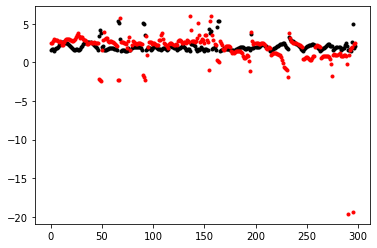

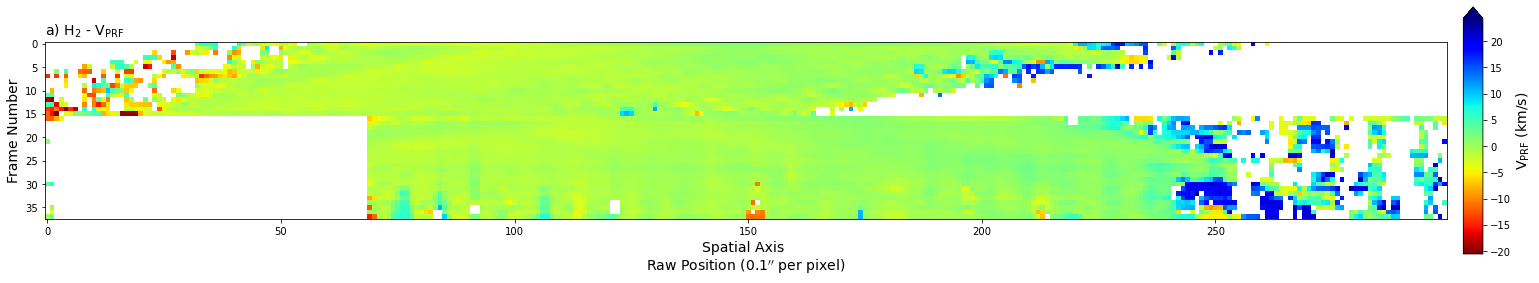

In [15]:
ang_diam = 40.58867
ang_diam/(0.1)
limb_vel = 12.572
vel_slope = limb_vel * 2 / (ang_diam/(0.1))

x = np.linspace(0,299,300)
rot_rate = vel_slope * x
rot_rate = rot_rate - rot_rate[150]

h2_plan_vel = h2_los_rel + 0

for i in range(np.size(h2_los_rel, 0)):
    h2_plan_vel[i,:] = h2_los_rel[i,:] - rot_rate


spatial_velocity = h2_los_rel + 0
spatial_velocity[::] = 0

for i in range(np.size(spatial_velocity, 1)):
    for j in range(1, np.size(spatial_velocity, 0)-1):
        if j not in (15,16):
            y = np.arange(3)
            p = np.array((h2_int_shifted[j-1][i], h2_int_shifted[j][i], h2_int_shifted[j+1][i]))
#             print(j,i)
#             plt.figure()
#             plt.plot(y, p, 'k', label='original')
            f = sp.interpolate.interp1d(y,p)
            xnew = np.linspace(0,2,7)
#             print(xnew)
#             plt.figure()
#             plt.plot(xnew, f(xnew), 'r.', label='interpolate')
#             plt.legend()
#             print(f(xnew[2]), f(xnew[4]))
            p1 = f(xnew[2])
#             print('p1='+str(p1))
#             rt1 = f(xnew[2])-(f(p[0])+((f(p[1])-f(p[0])) / (p[1]-p[0]))*(xnew[2])-p[0])
            rt1 = f(xnew[2])-(f(y[0])+((f(y[1])-f(y[0])) / (y[1]-y[0]))*(xnew[2])-y[0])
#             rt1 = f(xnew[2])-(f(xnew[1])+((f(xnew[3])-f(xnew[1])) / (xnew[3]-xnew[1]))*(xnew[2])-xnew[1])
#             print('rt1='+str(rt1))
            p3 = f(xnew[4])
#             print(p1)
#             print(p3)
#             print('xnew4='+str(xnew[4]))
#             print('p1='+str(f(p[1])))
#             print('p2='+str(f(p[2])))
#             test = f(p[1])
#             rt3 = f(xnew[4])-(f(p[1])+((f(p[2])-f(p[1])) / (p[2]-p[1]))*(xnew[4]-p[1]))
            rt3 = f(xnew[4])-(f(y[1])+((f(y[2])-f(y[1])) / (y[2]-y[1]))*(xnew[2])-y[1])
#             rt3 = f(xnew[4])-(f(xnew[3])+((f(xnew[5])-f(xnew[3])) / (xnew[5]-xnew[3]))*(xnew[4])-xnew[3])
            di = (p3 - p1)/(p3 + p1)
            sigx = np.sqrt(rt1**2+rt3**2)
            sigy = np.sqrt(rt1**2+rt3**2)
            rt = di*np.sqrt((sigx/(p3-p1))**2+(sigy/(p3+p1))**2)
            print(p3-p1)
#             print('rt='+str(rt))
            dv = 8*di
            
            if np.isreal(dv):
                spatial_velocity[j,i] = dv
                
spatial_velocity2 = spatial_velocity + 0
# spatial_velocity2[np.isnan(h2_int_shifted_error)] = np.nan
spatial_velocity2[spatial_velocity <= 1.5] = np.nan
# spatial_velocity2[spatial_velocity > 4] = np.nan

h2_plan_vel2 = h2_plan_vel + 0
# h2_plan_vel2[h2_plan_vel2 < -1] = np.nan
# h2_plan_vel2[h2_plan_vel2 > 5] = np.nan
h2_plan_vel2[h2_los_shifted_error > 0.8] = np.nan
h2_plan_vel2[np.isnan(spatial_velocity2)] = np.nan

spatial_velocity2[np.isnan(h2_plan_vel2)] = np.nan

a = spatial_velocity2[np.isfinite(spatial_velocity2)]
b = h2_plan_vel2[np.isfinite(h2_plan_vel2)]

# print(10/(np.mean(a[60:220])/np.mean(b[60:220])))
print(10/(np.mean(a[0:200])/np.mean(b[0:200])))

# spatial_velocity.shape
plt.figure()
plt.plot(a, 'k.')
plt.plot(b, 'r.')

h2_corrected_vel = h2_plan_vel - spatial_velocity
# h2_corrected_vel[h2_corrected_vel > 2] = 2
# h2_corrected_vel[h2_corrected_vel < -2] = -2

fig = plt.figure(figsize=(24,4), tight_layout=True)

fig.add_subplot(111)
plt.imshow(h2_corrected_vel*(-1), cmap='jet_r')
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=14)
plt.ylabel('Frame Number', fontsize=14)
plt.title('a) H$_2$ - V$_{\mathrm{PRF}}$', loc='left', fontsize=14)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='V$_{\mathrm{PRF}}$ (km/s)',size=14)

In [26]:
f

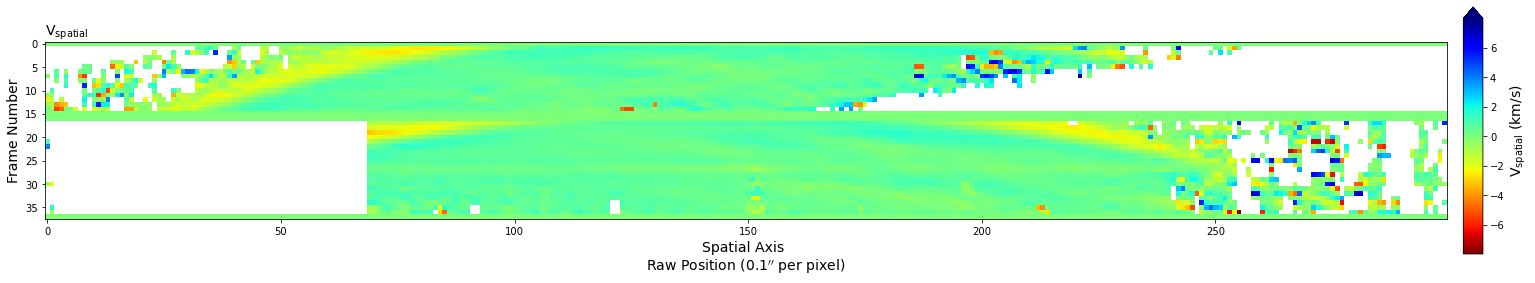

In [54]:
sv = spatial_velocity+0
# sv[sv<1] = np.nan

fig = plt.figure(figsize=(24,4), tight_layout=True)

fig.add_subplot(111)
plt.imshow(sv*(-1), cmap='jet_r')
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=14)
plt.ylabel('Frame Number', fontsize=14)
plt.title('V$_{\mathrm{spatial}}$', loc='left', fontsize=14)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='V$_{\mathrm{spatial}}$ (km/s)',size=14)

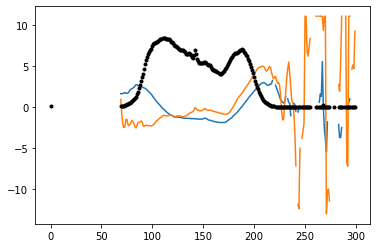

In [72]:
plt.figure()
plt.plot(sv[17]*1.5)
plt.plot(h2_los_rel[17])
plt.plot(h2_int_shifted[17]*5e2, 'k.')

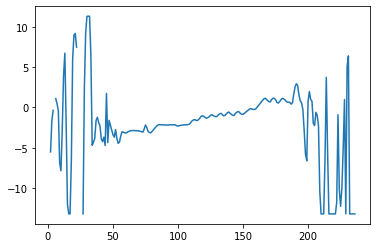

In [42]:
spatial_velocity*(-1)/10

array([[-0.        , -0.        , -0.        , ..., -0.        ,
        -0.        , -0.        ],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       ...,
       [        nan,  0.22687416,         nan, ...,  0.04757839,
                nan,         nan],
       [        nan, -0.11312677,         nan, ...,  0.06251457,
                nan,         nan],
       [-0.        , -0.        , -0.        , ..., -0.        ,
        -0.        , -0.        ]])

In [42]:
0.432/0.288*25000

37500.0

In [3]:
R36 = 73194.84858495607
R32 = 72803.45487481622
R37 = 72736.04543958924
R35 = 73234.23454151815
R34 = 72543.25347866818
Rh3p = np.mean((R36,R37,R35))
Rh2 = np.mean((R36))
Rh3p

73055.04285535449

In [4]:
a1 = 299781.458/(Rh3p/2)
a2 = 299781.458/(75000/2)
(a1-a2)/a2

0.02662317437136317

In [6]:
a2

7.994172213333333

In [15]:
sp.stats.sem((a1,a2))

0.10641512039513978

In [14]:
np.std((a1,a2))

0.10641512039513978

In [7]:
x = a[60:220]
y = b[60:220]
z = (np.mean(x)/np.mean(y))
z

1.2600803741445634

In [8]:
z * np.sqrt((np.std(x)/np.mean(x))**2 + (np.std(y)/np.mean(y))**2)

0.5310719648533606

In [9]:
# z = (np.mean(a)/np.mean(b))
z * np.sqrt((np.std(a)/np.mean(a))**2 + (np.std(b)/np.mean(b))**2)

0.5782128888438188